# Spatial analysis of links and clicked links

## Introduction

In this notebook, we want to perform an analysis of where are located the links on whose people click, and copare those locations with the global coordinates distribution of links in the whole wikispeedia data (i.e. we will extract the coordinates of all the links in all the pages, and then compare the distribution of these coordinates xith the distibution of the coordinates of links clicked to see if people tend to click randomly or if there are tendancies in the position of links clicked)

In [1]:
#Import all the necessary librairies
import os
import numpy as np
import pandas as pd
import pickle
from scipy.stats import ttest_ind
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from urllib.parse import quote, urlparse, urlunparse, unquote
import lxml
from pathlib import Path
import seaborn as sns
import matplotlib.patches as mpat

from selenium import webdriver

### Extraction of links coordinates

We would like to obtain the coordinate of every link in every page. In order to do that, we use the librairies **selenium** which permits to open a webbrowser and performs actions on the page. Once the webbrowser opened, we iterate over all the html files of the dataset and using javascript, we extract the coordinates of the links in the opened page, and we put everything in a DataFrame

In [150]:
directory = r'data/wikispeedia_articles_html/wpcd/wp/'

df_test_2 =pd.DataFrame(columns=['X', 'Y', 'link', 'page', 'distance', 'href'])
driver = webdriver.Firefox()
j = 0

for filename in tqdm(os.listdir(directory)):
  f = os.path.join(directory, filename)
  for file in os.listdir(f):

    page = 'file://'+os.getcwd()+'/' + os.path.join(f,quote(file))

    path = Path(page)
    if path.suffix != '.htm':
      continue
    driver.get(page)

    js = '''function getCoords(elem) {let box = elem.getBoundingClientRect();return {X : box.left + window.pageXOffset, Y : box.top + window.pageYOffset, Link : elem.getAttribute('title'), href : elem.getAttribute('href')};}
    const allElements = document.getElementsByTagName('a');
    coords = [document.title]
    for (const element of allElements) {
      if (element.classList != 'image' && element.classList != 'internal' && element.title.length > 0){
        coords.push(getCoords(element))
    }
    }
    return coords
    '''
    test = driver.execute_script(js)
    for i in range(1, len(test)):
      df_test_2.loc[j] = [test[i]['X'], test[i]['Y'], test[i]['Link'], test[0], np.sqrt(test[i]['X']**2 + test[i]['Y']**2), test[i]['href']] 
      j += 1
    j +=1
driver.quit()


100%|██████████| 37/37 [1:00:58<00:00, 98.89s/it] 


### Cleaning and clicked links coordinates extraction

In order to avoid the maximum of errorr of the type : the link in the path $\neq$ the title of the page that the link points toward to, we have also extracted the **href** toward which the link points. Then, when using the dataframe to search for the link clicked coordinates in the page, we can either use the link title or the link href, which minimizes error rate. We then put the final data in the Dataframe **final_df**

Then we use this dataframe to extract the (x,y) coordinates of all the clicked links, 



In [158]:
def unquote_u(source):
  result = source
  if '%u' in result:
    result = result.replace('%u','\\u').decode('unicode_escape')
  result = unquote(result)
  return result

def split_href(string):
    result = string.split('/')[-1]
    result = result.split('.')[0]
    return result.replace('_', ' ')

df_test_2['href'] = df_test_2['href'].apply(split_href)

In [2]:
final_df = pd.read_pickle('data/final_df.pkl')
final_df.head()

,X,Y,link,page,distance
0,211.649994,74.949997,Dál Riata,Áedán mac Gabráin,224.528889
1,281.850006,74.949997,Kingdom,Áedán mac Gabráin,291.645209
2,432.149994,74.949997,Scotland,Áedán mac Gabráin,438.601322
3,597.750000,74.949997,Ireland,Áedán mac Gabráin,602.430547
4,939.750000,74.949997,Columba,Áedán mac Gabráin,942.734090


In [34]:
directory1 = r"data\wikispeedia_paths-and-graph\wikispeedia_paths-and-graph\paths_finished.csv"
directory2 = r"data\wikispeedia_paths-and-graph\wikispeedia_paths-and-graph\paths_unfinished.csv"
path_finished = pd.read_csv(directory1, sep = ';', encoding="iso-8859-1")
path_unfinished = pd.read_csv(directory2, sep = ';')

path_finished

,userID,timestamp,duration,path,rating
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0
...,...,...,...,...,...
51313,15a13a1d66ef5456,1349231015,66,Yagan;Ancient_Egypt;Civilization,NaN
51314,2ef7ac844cefda58,1300254138,165,Yagan;Folklore;Brothers_Grimm;<;19th_century;C...,3.0
51315,12863abb7887f890,1385095372,228,Yagan;Australia;England;France;United_States;T...,NaN
51316,19f8284371753362,1298792567,56,Yarralumla%2C_Australian_Capital_Territory;Aus...,1.0


In [185]:
#Now we want to use the links_in_pages dataframe that contains the posistion of links in the page and the dataframe of path to see if we can spot trends in position of links clicked
links_in_pages = pd.read_pickle('data/links_in_pages_DF.pkl')
x_coordinate_list_2 = []
y_coordinate_list_2 = []

for links in tqdm(path_finished['path']):
    links = links.split(";")
    links_def = [unquote(x.replace('_', ' ')) for x in links]

    if '<' in links_def:
            continue

    for i in range(len(links_def)-1):
        link_dummy = links_def[i+1]
        page_dummy = links_def[i]
        if page_dummy == 'Color':
            page_dummy = 'Colour'
        coordinate = df_test_2.query("page == @page_dummy & link == @link_dummy")
        coordinate_2 = df_test_2.query("page == @page_dummy & href == @link_dummy")
        if len(coordinate)>0:
            x_coordinate_list_2.append(coordinate.iloc[0]['X']) #We assume that the link clicked is always the first one
            y_coordinate_list_2.append(coordinate.iloc[0]['Y'])
        elif len(coordinate_2)>0:
            x_coordinate_list_2.append(coordinate_2.iloc[0]['X']) #We assume that the link clicked is always the first one
            y_coordinate_list_2.append(coordinate_2.iloc[0]['Y'])
            df_test_2['link'].loc[(df_test_2['page'] == page_dummy) & (df_test_2['href'] == link_dummy)] = df_test_2['href'].loc[(df_test_2['page'] == page_dummy) & (df_test_2['href'] == link_dummy)]
        else:
            break
            

 37%|███▋      | 18809/51318 [56:40<1:21:40,  6.63it/s]C:\Users\croge\AppData\Local\Temp\ipykernel_51064\4085582987.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_2['link'].loc[(df_test_2['page'] == page_dummy) & (df_test_2['href'] == link_dummy)] = df_test_2['href'].loc[(df_test_2['page'] == page_dummy) & (df_test_2['href'] == link_dummy)]
100%|██████████| 51318/51318 [2:29:02<00:00,  5.74it/s]  


In [76]:
path_links = pd.DataFrame(columns=['userID', 'timestamp', 'x_list', 'y_list'])
j=0
for links in tqdm(path_finished['path']):
    skip = False
    x_list_path = []
    y_list_path = []
    links = links.split(";")
    links_def = [unquote(x.replace('_', ' ')) for x in links]

    if '<' in links_def:
        j+=1
        continue
    for i in range(len(links_def)-1):
        link_dummy = links_def[i+1]
        page_dummy = links_def[i]
        coordinate = links_in_pages.query("page == @page_dummy & link == @link_dummy")
        if len(coordinate)>0:
            x_list_path.append(coordinate.iloc[0]['X']) #We assume that the link clicked is always the first one
            y_list_path.append(coordinate.iloc[0]['Y'])
        else:
            j+=1
            break

    path_links.loc[j] = [path_finished.loc[j]['userID'], path_finished.loc[j]['timestamp'], x_list_path, y_list_path]
    j+=1


100%|██████████| 51318/51318 [1:22:02<00:00, 10.42it/s]


In [13]:
path_links = pd.read_pickle('data/path_links.pkl')
path_links

,userID,timestamp,x_list,y_list
0,6a3701d319fc3754,1297740409,"[1115.316650390625, 1115.316650390625, 611.400...","[95.51666259765624, 95.51666259765624, 2816.56..."
1,3824310e536af032,1344753412,"[365.7000122070313, 650.8499755859375, 206.25,...","[215.13333129882812, 176.5500030517578, 1891.5..."
2,415612e93584d30e,1349298640,"[377.3999938964844, 19.050003051757812, 610.34...","[498.2999877929687, 136.38333129882812, 448.56..."
3,64dd5cd342e3780c,1265613925,"[1128.0, 202.3000030517578, 368.0]","[538.933349609375, 839.9500122070312, 195.6000..."
4,015245d773376aab,1366730828,"[366.6000061035156, 404.25, 1157.9000244140625...","[194.8166656494141, 176.5500030517578, 9828.58..."
...,...,...,...,...
51310,55150dce4acb74c8,1340891297,"[133.5, 834.4500122070312, 1198.050048828125, ...","[309.8833312988281, 4346.7998046875, 94.0, 179..."
51313,15a13a1d66ef5456,1349231015,"[708.4500122070312, 203.5500030517578]","[2084.716552734375, 74.94999694824219]"
51315,12863abb7887f890,1385095372,"[954.1500244140624, 755.4000244140625, 496.049...","[113.0500030517578, 554.066650390625, 1440.066..."
51316,19f8284371753362,1298792567,"[465.4500122070313, 575.7999877929688, 19.0500...","[100.35000610351562, 1395.13330078125, 2641.48..."


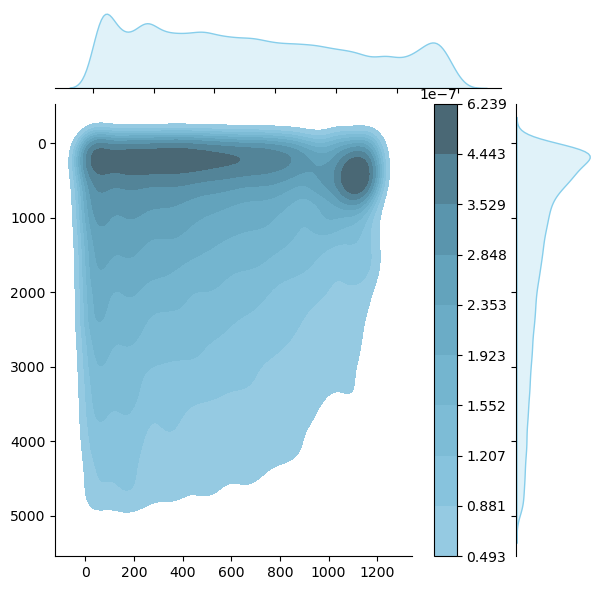

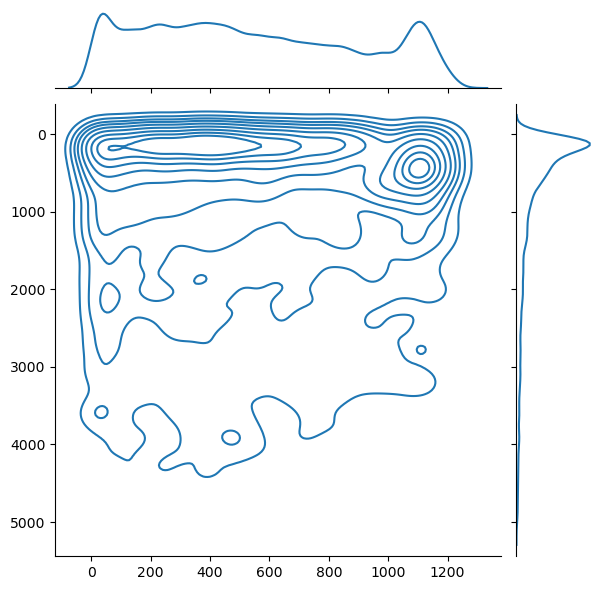

test


In [3]:
links_in_pages = pd.read_pickle('data/links_in_pages_DF.pkl')

with open('data/x_coordinate_list.pkl', 'rb') as file:
    x_coordinate_list = pickle.load(file)

with open('data/y_coordinate_list.pkl', 'rb') as file_2:
    y_coordinate_list = pickle.load(file_2)

x_list = []
y_list = []

for i in range(len(x_coordinate_list)):
    if x_coordinate_list[i]>0 and y_coordinate_list[i]>0 and y_coordinate_list[i]<5000:
        x_list.append(x_coordinate_list[i])
        y_list.append(y_coordinate_list[i])
        
'''
with open('data/x_coordinate_list.pkl', "rb") as input_file:
    x_coordinate_list = pickle.load(input_file)

with open('data/y_coordinate_list.pkl', "rb") as input_file:
    y_coordinate_list = pickle.load(input_file)

'''
clicked_links = pd.DataFrame({'X' : x_list,
'Y' : y_list})


filtered_df = links_in_pages.query('Y < 5000 & Y > 0')
filtered_df = filtered_df.query('X < 1200 & X > 0')

jointplot_2 = sns.jointplot(x=list(filtered_df['X']), y=list(filtered_df['Y']), kind='kde', fill = True, cbar=True, color='skyblue')
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
plt.show()

jointplot = sns.jointplot(x  = x_list , y = y_list , kind = 'kde')
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
#cbar_ax = jointplot.fig.add_axes([.85, .25, .05, .4])

plt.show()
print('test')


In [28]:
#lets define two vectors of distances from the top left in order to compare both clicked links and links in page
distance_links = [x for x in np.array(links_in_pages['distance']) if x<5200]
distance_clicked = np.zeros(len(distance_links))

for i in range(1, len(distance_links)):
    distance_clicked[i] = np.sqrt(x_list[i]**2 + y_list[i]**2)



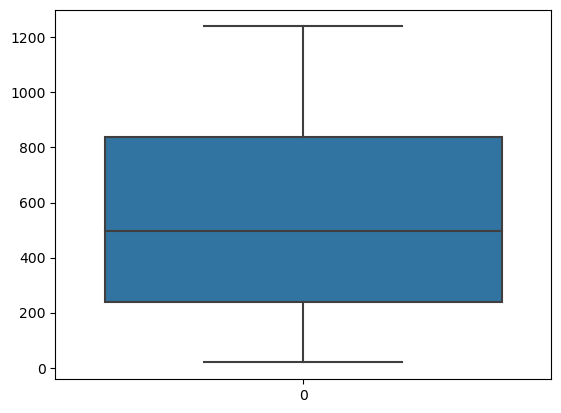

In [19]:
#descriptive stats of clicked links (y<5000)

clicked_links[['X', 'Y']].describe()

boxplot = sns.boxplot(clicked_links['X'])

c:\Users\croge\anaconda3\envs\ada\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


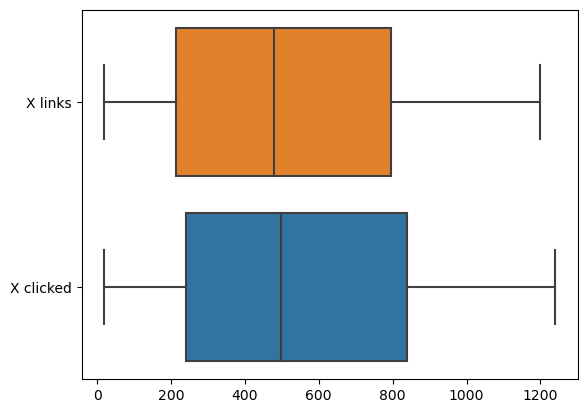

c:\Users\croge\anaconda3\envs\ada\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


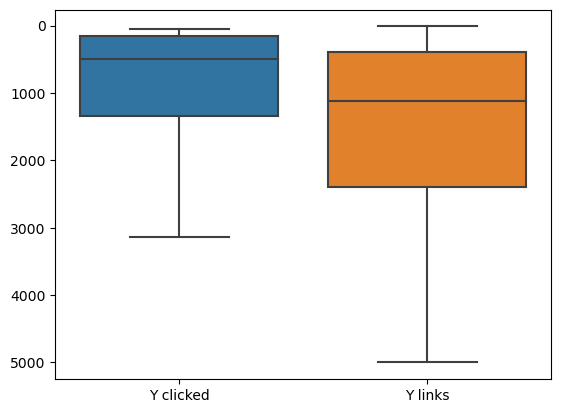

In [25]:
X_coordinates = pd.DataFrame({'X clicked' : clicked_links['X'],
'X links' : filtered_df['X']})

Y_coordinates = pd.DataFrame({'Y clicked' : clicked_links['Y'],
'Y links' : filtered_df['Y']})


sns.boxplot(X_coordinates, orient='h')
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])

plt.show()

sns.boxplot(Y_coordinates, showfliers = False)
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])

plt.show()

c:\Users\croge\anaconda3\envs\ada\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot: >

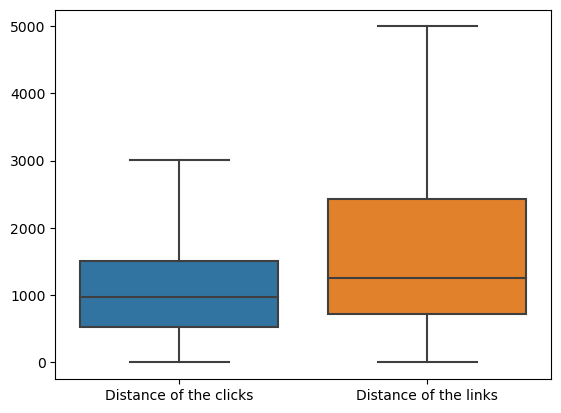

In [30]:
#comparison beween distance of the clicks and the distance of the links globally
Distances = pd.DataFrame({'Distance of the clicks' : distance_clicked,
'Distance of the links' : distance_links})
plt.figure()
sns.boxplot(Distances, showfliers = False)